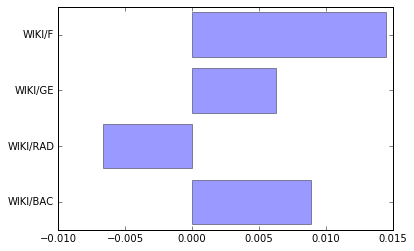

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 24 16:43:20 2017

@author: nandanthor
"""

# We are going to build a machine learning model to try to predict stock prices

#Imports - we'll use quandl for the stock data
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor

# List of ticker symbols we want to predict
tickers = ['WIKI/BAC', 'WIKI/RAD', 'WIKI/GE', 'WIKI/F']

#Instantiate empty list of predictors
predicts = []

#Start for loop
for i in range(len(tickers)):
    #Get historical data
    data = quandl.get(tickers[i], authtoken='TBRdSMHYKwL7HbrVKxT3', trim_start='2010-01-01', collapse='weekly')
    #Get test data
    data_test = quandl.get(tickers[i], authtoken='TBRdSMHYKwL7HbrVKxT3', trim_start='2017-01-24')
    data.append(data_test)

    price = data['Adj. Close']
    
    #Compute daily returns
    daily_ret = (price / price.shift(1))-1
    
    #Compute rolling mean and rolling standard deviation (for Bollinger Bands)
    rm = price.rolling(center=False, window = 20).mean()
    sd = price.rolling(center=False, window = 20).std()
    
    #Build dataframe
    df = pd.concat([price, daily_ret, rm, sd], axis = 1)
    df.columns.values[0]='Price'
    df.columns.values[1]='Daily Ret'
    df.columns.values[2]='Roll Mean'
    df.columns.values[3]='Roll Std'
    
    #For loop for bollinger bands
    bb = []
    for i in range(len(df)):
        up_ran = df['Roll Mean'][i] + (2 * df['Roll Std'][i])
        low_ran = df['Roll Mean'][i] - (2 * df['Roll Std'][i])
        if df['Price'][i] >= up_ran and df['Price'][i] >= low_ran:
            bb.append(0)
        else:
            bb.append(1)
    bollb = pd.Series(bb)
    df['Boll Bonds'] = bollb.values
    
    #Now compute Sharpe Ratio
    ##Assume risk-free rate is 2.4%
    sr = (df['Daily Ret'] - .024) / df['Roll Std']
    df1 = pd.concat([df, sr], axis = 1)
    df1.columns.values[5]='Sharpe Ratio'
    
    #Cut out NaNs - we use a 20 period window for our rolling statistics, so we cut out the first 20 data points
    df2 = df1.ix[20:]
    
################################################################################################
    
    #Build our X and y for machine learning
    y = df2['Daily Ret'][:-1]
    X = df2.drop(['Price', 'Daily Ret'], 1)[:-1]

    X_train = X[:-1]
    y_train = y[1:]

    X_test = X.ix[-1:]
    
    #Build regressor
    clf = BaggingRegressor()
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
#    print(preds)

    predicts.append(preds)

outs = list(zip(tickers, predicts))
#print(outs)
%matplotlib inline
#Plot our results!
y_pos= np.arange(len(tickers))
plt.barh(y_pos, predicts, align='center', alpha=0.4)
plt.yticks(y_pos, tickers)
plt.show()


In [ ]:
# So we predict Ford, GE, and Bank of America to increase, and Rite Aid to decrease.  If we look at Jan. 25, 2017 
#stock data, the predictions were correct. F = +.18, GE = +.37, BAC = +.42, RAD = -.05